# Import Libraries Used

In [85]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
from mpl_toolkits.mplot3d import Axes3D
from Utilities.plot import histvstarget, distribution

# Import the data

Remember from the data exploration notebook that we now have three different data sets now, the original, one with PCA and one with attribute selection using BFE.

First lets take 20% of the data out to be used as a joint test-set.

In [86]:
data_m = pd.read_csv('input/Diabetes_MissingvalesLabeled.csv')
ground = data_m['Outcome']
data_temp = data_m.drop(['Outcome'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(data_temp, ground, test_size=0.2)
data = pd.DataFrame(np.hstack((x_train, y_train[:,np.newaxis])), columns = data_m.columns)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,10.0,115.0,NaN,NaN,NaN,NaN,0.261,30.0,1.0
1,4.0,76.0,62.0,NaN,NaN,34.0,0.391,25.0,0.0
2,2.0,142.0,82.0,18.0,64.0,24.7,0.761,21.0,0.0
3,1.0,157.0,72.0,21.0,168.0,25.6,0.123,24.0,0.0
4,5.0,97.0,76.0,27.0,NaN,35.6,0.378,52.0,1.0


In [87]:

# Recreate dataset with PCA
import Utilities.mypca as PCA
datanoNan = data.dropna(axis=0)
PCA_ytrain = datanoNan["Outcome"]
data_temp = datanoNan.drop(["Outcome"], axis=1)
pca = PCA.MyPCA()
pca.fit(data_temp)
PCA_xtrain = pca.fit_transform(4, data_temp)
PCA_data = pd.DataFrame(PCA_xtrain, columns = ['PC1','PC2','PC3','PC4'])
PCA_data["Outcome"] = PCA_ytrain.values
print(PCA_data.shape)
PCA_data.head()

(306, 5)


,PC1,PC2,PC3,PC4,Outcome
0,86.678042,-141.866213,59.512148,12.672200,0.0
1,191.721254,-139.727914,52.242278,7.729227,0.0
2,201.028855,-121.693970,58.339153,6.020869,0.0
3,82.924360,-142.751222,81.948316,25.339636,0.0
4,79.423896,-134.169910,90.616900,5.409974,1.0


In [88]:
BFE_cols = ["Glucose", "SkinThickness", "BMI", "Age", "DiabetesPedigreeFunction"]
BFE_data = data[BFE_cols + ["Outcome"]]
BFE_data.head()
BFE_data = BFE_data.dropna(axis=0)
BFE_xtrain = BFE_data[BFE_cols]
BFE_ytrain = BFE_data["Outcome"]
print(BFE_data.shape)
BFE_data.head()

(432, 6)


,Glucose,SkinThickness,BMI,Age,DiabetesPedigreeFunction,Outcome
2,142.0,18.0,24.7,21.0,0.761,0.0
3,157.0,21.0,25.6,24.0,0.123,0.0
4,97.0,27.0,35.6,52.0,0.378,1.0
5,90.0,32.0,34.9,56.0,0.825,1.0
6,140.0,26.0,24.1,23.0,0.828,0.0


# Baseline with Logistic Regression

Lets establish a baseline for the problem by using 10 fold cross validation and the, probably, simplest classification method out there: Logistic regression. 

In [135]:
kfold = KFold(n_splits=10, random_state=22)
PCA_xtrain_normalized = PCA_xtrain / PCA_xtrain.max(axis=0)
Baseline_PCA_result = cross_val_score(LogisticRegression(), PCA_xtrain_normalized, PCA_ytrain, cv = kfold,scoring = "accuracy")
Baseline_PCA_score = Baseline_PCA_result.mean()
print(Baseline_PCA_score)

0.751505376344


In [129]:
Baseline_BFE_result = cross_val_score(LogisticRegression(), BFE_xtrain, BFE_ytrain, cv = kfold,scoring = "accuracy")
Baseline_BFE_score = Baseline_BFE_result.mean()
print(Baseline_BFE_score)

0.771088794926


[<matplotlib.text.Text at 0x118cb4550>, <matplotlib.text.Text at 0x118cbf080>]

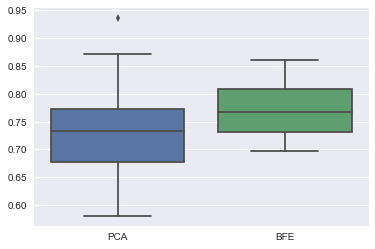

In [128]:
np.vstack((np.transpose(Baseline_PCA_result), np.transpose(Baseline_BFE_result)))
res = []
res.append(Baseline_PCA_result)
res.append(Baseline_BFE_result)
ax = sns.boxplot(data=res)
ax.set_xticklabels(["PCA","BFE"])

It looks like PCA is not doing that great in comparison with the attributes extracted using BFE. The accuracy of logistic regression on PCA is centered around 0.74 whereas the accuracy for BFE is centered around 0.77. So we will drop the PCA dataset.

# Building our model